<a href="https://colab.research.google.com/github/MennoLPomp/MennoLPomp/blob/main/EF_ASS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Empirical Finance assignment 1

* Menno Pomp - 2016110
* Edward Schouten - 2022035
* Cascha van Wanrooij - 2014934

---

### Setup up/data exploring

* Obtain returns from Kenneth R. French library (download, unzip and load csv)
* Obtain aggregate consumption data from Harvard
* Display summary statistics and basic graphs

In [ ]:
!pip install Stargazer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from stargazer.stargazer import Stargazer


from scipy.stats import norm
from scipy.optimize import curve_fit

plt.rcParams['axes.grid'] = True

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_daily_CSV.zip
!wget https://scholar.harvard.edu/files/barro/files/barro_ursua_macrodataset_1110.xls
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip

--2021-09-24 06:36:08--  https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_daily_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 493395 (482K) [application/x-zip-compressed]
Saving to: ‘5_Industry_Portfolios_daily_CSV.zip’

5_Industry_Portfoli 100%[===================>] 481.83K  2.63MB/s    in 0.2s    

2021-09-24 06:36:09 (2.63 MB/s) - ‘5_Industry_Portfolios_daily_CSV.zip’ saved [493395/493395]

--2021-09-24 06:36:09--  https://scholar.harvard.edu/files/barro/files/barro_ursua_macrodataset_1110.xls
Resolving scholar.harvard.edu (scholar.harvard.edu)... 18.208.82.203, 18.232.209.104
Connecting to scholar.harvard.edu (scholar.harvard.edu)|18.208.82.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7516672 (7.2M) [application/vnd.ms-excel]
Sav

In [ ]:
!unzip "5_Industry_Portfolios_daily_CSV.zip" -d ""
!unzip "F-F_Research_Data_5_Factors_2x3_daily_CSV.zip" -d ""
!unzip "F-F_Momentum_Factor_CSV.zip" -d ""

Archive:  5_Industry_Portfolios_daily_CSV.zip
  inflating: 5_Industry_Portfolios_Daily.csv  
Archive:  F-F_Research_Data_5_Factors_2x3_daily_CSV.zip
  inflating: F-F_Research_Data_5_Factors_2x3_daily.CSV  
Archive:  F-F_Momentum_Factor_CSV.zip
  inflating: F-F_Momentum_Factor.CSV  


In [ ]:
# skip first rows (explanation of data), and last rows (average weighted returns (we weigh by value for now!))
df_industry = pd.read_csv('5_Industry_Portfolios_Daily.csv', skiprows=9, skipfooter=25045, engine='python')
df_industry.columns = ['Date', *df_industry.columns[1:]]
df_industry['Date'] = pd.to_datetime(df_industry['Date'], format='%Y%m%d')
df_industry.set_index('Date', inplace=True)

# cast to returns
df_industry = df_industry/100 + 1

df_industry.describe().round(4)

Cnsmr       Manuf       HiTec       Hlth        Other
count  25041.0000  25041.0000  25041.0000  25041.0000  25041.0000
mean       1.0005      1.0004      1.0005      1.0005      1.0004
std        0.0102      0.0112      0.0120      0.0110      0.0124
min        0.8277      0.8162      0.8111      0.8211      0.8477
25%        0.9960      0.9959      0.9955      0.9956      0.9956
50%        1.0007      1.0007      1.0006      1.0006      1.0007
75%        1.0052      1.0053      1.0056      1.0057      1.0056
max        1.1705      1.1625      1.1555      1.1262      1.1801

In [ ]:
df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=2, engine='python')
df_ff.columns = ['Date', *df_ff.columns[1:]]
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format='%Y%m%d')
df_ff.set_index('Date', inplace=True)

# cast to returns
df_ff = df_ff/100 + 1

df_ff.describe().round(4)

Mkt-RF         SMB         HML         RMW         CMA          RF
count  14621.0000  14621.0000  14621.0000  14621.0000  14621.0000  14621.0000
mean       1.0003      1.0001      1.0001      1.0001      1.0001      1.0002
std        0.0101      0.0054      0.0056      0.0038      0.0036      0.0001
min        0.8256      0.8877      0.9505      0.9698      0.9411      1.0000
25%        0.9959      0.9973      0.9977      0.9983      0.9982      1.0001
50%        1.0005      1.0002      1.0001      1.0001      1.0001      1.0002
75%        1.0050      1.0030      1.0025      1.0018      1.0019      1.0002
max        1.1135      1.0617      1.0675      1.0451      1.0253      1.0006

In [ ]:
df_mom = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=12, skipfooter= 99, engine='python')

df_mom.columns = ['Date', *df_mom.columns[1:]]
df_mom['Date'] = pd.to_datetime(df_mom['Date'], format='%Y%m')
df_mom.set_index('Date', inplace=True)

#cast to returns
df_mom = df_mom/100 + 1

df_mom.describe().round(4)

Mom   
count  1135.0000
mean      1.0064
std       0.0472
min       0.4795
25%       0.9906
50%       1.0079
75%       1.0295
max       1.1820

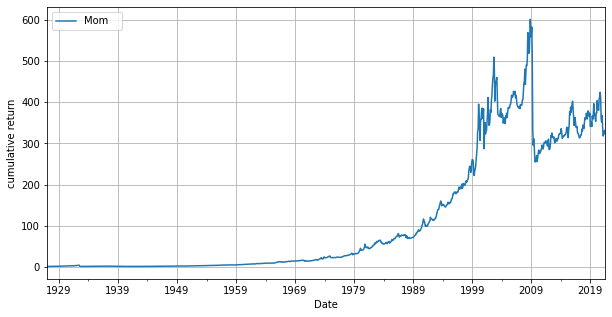

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))

df_mom.cumprod().plot(ax=ax)
ax.set_ylabel('cumulative return')
fig.savefig('cum_return_mom.png', dpi=200)

In [ ]:
df_macro = pd.read_excel('barro_ursua_macrodataset_1110.xls', sheet_name='C', usecols=[0, 41], skiprows=45, names=['Date', 'C'])
df_macro['Date'] = pd.to_datetime(df_macro['Date'], format='%Y')
df_macro.set_index('Date', inplace=True)

(df_macro/df_macro.shift(1)).round(4).describe().to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &           C \\\\\n\\midrule\ncount &  175.000000 \\\\\nmean  &    1.015618 \\\\\nstd   &    0.038818 \\\\\nmin   &    0.904800 \\\\\n25\\%   &    0.993450 \\\\\n50\\%   &    1.015000 \\\\\n75\\%   &    1.039250 \\\\\nmax   &    1.116800 \\\\\n\\bottomrule\n\\end{tabular}\n'

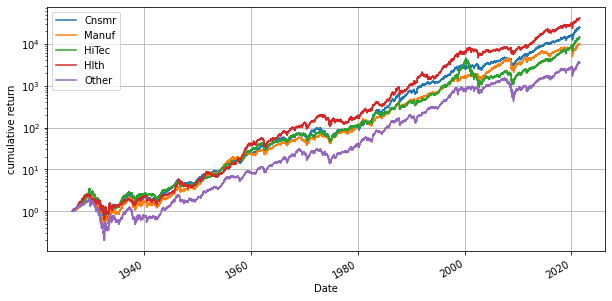

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
df_industry.cumprod().plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('cumulative return')

fig.savefig('cum_return.png', dpi=200)

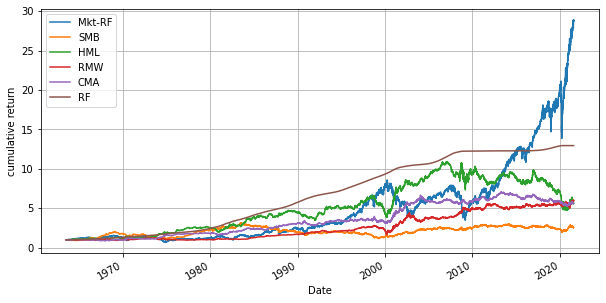

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))

df_ff.cumprod().plot(ax=ax)
ax.set_ylabel('cumulative return')

fig.savefig('cum_return_ff.png', dpi=200);

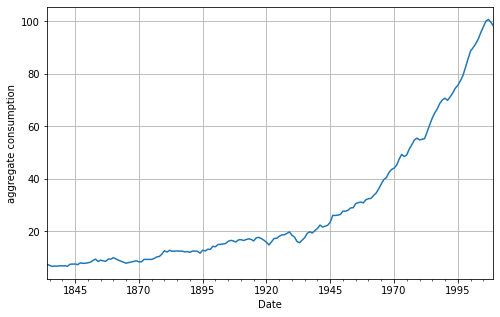

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(8,5))
df_macro['C'].plot(ax=ax);

ax.set_ylabel('aggregate consumption')
fig.savefig("cum_cons.png", dpi = 200)

---

### Stylized Facts

In [ ]:
def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries
    Args:
        x (2d array): x contains the time series in the shape (timestep, sample).
        k (int): window length.
        sparse (bool): Cut off the final windows containing NA. Defaults to True.
    Returns:
        3d array: array of rolling windows in the shape (window, timestep, sample).
    """    
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]
            
    if not sparse:
        return out

    return out[:, :-(k-1)]

In [ ]:
def acf(x, k, le=False):

    ''' autocorrelation function '''

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [ ]:
def power_law(x, a, b):
    return a*np.power(x, b)

acf_cnsmr = acf(abs(df_industry['Cnsmr']-1), 100, le=False)

pars, cov = curve_fit(f=power_law, xdata=range(1, len(acf_cnsmr) + 1), ydata=acf_cnsmr, p0=[0, 0], bounds=(-np.inf, np.inf))

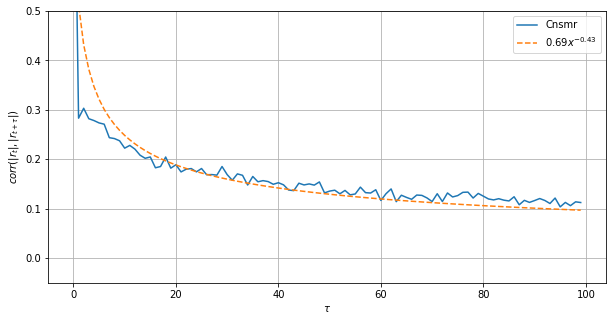

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))


ax.plot(acf(abs(df_industry['Cnsmr']-1), 100, le=False))
ax.plot(power_law(np.arange(1, 101), *pars), linestyle='dashed')
ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')
ax.legend(['Cnsmr', '$0.69x^{-0.43}$'])
ax.set_xlabel('$\\tau$')

fig.savefig('slow_decay.png', dpi=200)

#### Aggregational Gaussianity

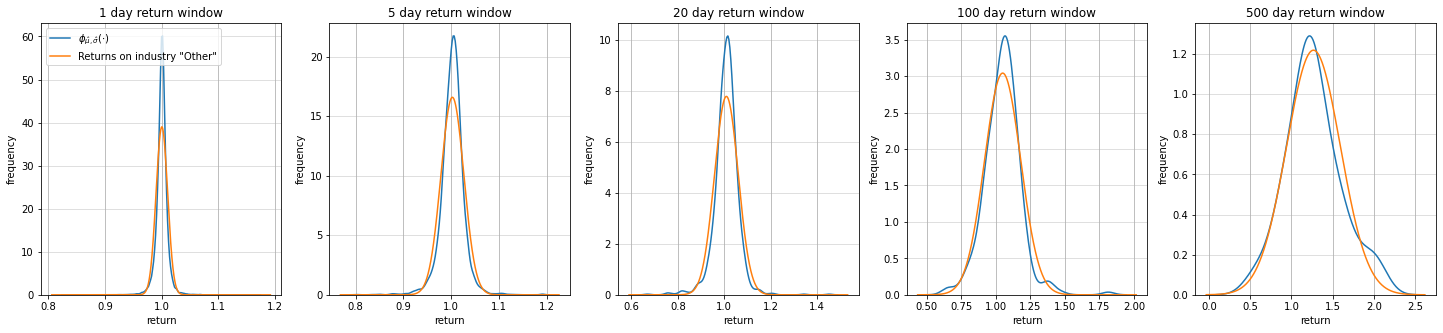

In [ ]:
from scipy.stats import skewtest, kurtosistest

returns = df_industry['Cnsmr'].to_numpy().reshape((-1,1))

windows = [1, 5, 20, 100, 500]
n_bins = 100

tests = np.zeros((len(windows), 2))

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))

for i in range(len(windows)):
    dist = rolling_window(returns, windows[i], sparse = not (windows[i] == 1)).prod(axis=0)[::windows[i]].ravel()
    sns.kdeplot(dist, ax=ax[i])
    x_range = np.linspace(*ax[i].get_xlim(), 10000)
    ax[i].plot(x_range, norm.pdf(x_range, dist.mean(), dist.std()))
    #ax[i].set_xlim(*np.quantile(dist, [0.0001, .9999]))
    ax[i].set_title('{} day return window'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('return')
    ax[i].set_ylabel('frequency')

    tests[i] = (skewtest(dist).pvalue, kurtosistest(dist).pvalue)


ax[0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'Returns on industry \"Other\"'], loc='upper left')

fig.savefig('agg_gaus', dpi=200)

In [ ]:
pd.DataFrame(tests, columns=['Skewness p', 'Kurtosis p'], index=pd.Series(windows, name='window length (days)')).round(3)

Skewness p  Kurtosis p
window length (days)                        
1                          0.000       0.000
5                          0.000       0.000
20                         0.374       0.000
100                        0.000       0.000
500                        0.251       0.471

---

### Asymmetry in time scales

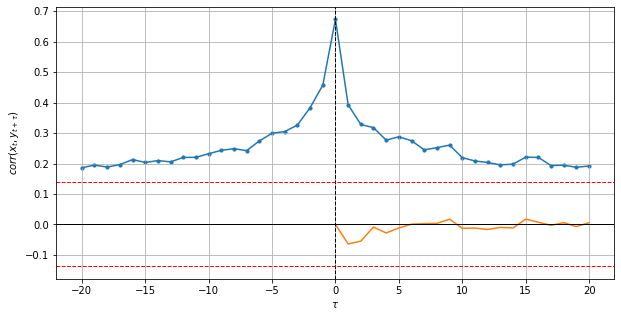

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))

returns = (df_industry['Cnsmr'] - 1).to_numpy().reshape((-1,1))

coarse_vol = abs(rolling_window(returns, 5, sparse = True).sum(axis=0)[::5].ravel())
fine_vol = rolling_window(abs(returns), 5, sparse = True).sum(axis=0)[::5].ravel()

corr_cf = np.zeros(41)

for tau in range(-20,21):
  if tau < 0:
    corr_cf[20 + tau] = np.corrcoef(coarse_vol[:tau],fine_vol[-tau:])[0,1]
  elif tau == 0:
    corr_cf[20 + tau] = np.corrcoef(coarse_vol, fine_vol)[0,1]
  else:
    corr_cf[20 + tau] = np.corrcoef(coarse_vol[tau:], fine_vol[:-tau])[0,1]


diff_corr = corr_cf - corr_cf[::-1]
diff_corr = -1*diff_corr[0:21][::-1]


df_corr_cf = pd.DataFrame(corr_cf, index = np.arange(-20,21) )
df_diff_corr = pd.DataFrame(diff_corr, index = np.arange(0,21))

#tau = [-20,-15,-10,-5,0,5,10,15,20]
#values = range(len(tau))
plt.plot(df_corr_cf)
plt.scatter(range(-20,21), df_corr_cf, s=10)
plt.plot(df_diff_corr)

random_walk_975 = np.quantile(np.random.normal(size=(21, int(1e6)), scale=df_diff_corr.std()).cumsum(axis=0), 0.975)

lb_corr = -1*random_walk_975
ub_corr = random_walk_975

#lb_corr = 0 - 1.96 * df_diff_corr.std()/np.sqrt(len(df_diff_corr))
#ub_corr = 0 + 1.96 * df_diff_corr.std()/np.sqrt(len(df_diff_corr))


plt.xlabel("$\\tau$")
plt.ylabel('$corr(x_t, y_{t+\\tau})$')
plt.axvline(x=0,ymin=0,ymax=1,linewidth = 1,color="k",ls="--")
plt.axhline(y=0,xmin=0,xmax=1,linewidth=1,color="k")
plt.axhline(y=lb_corr,xmin=0,xmax=1,linewidth=1,color="r", ls='dashed')
plt.axhline(y=ub_corr,xmin=0,xmax=1,linewidth=1,color="r", ls='dashed')

fig.savefig('asymmetry.png', dpi=200)

### Predictability

In [ ]:
df_industry['is_monday'] = df_industry.index.weekday == 0

In [ ]:
X = df_industry[['is_monday']].to_numpy().astype('int') # double brackets to return 2d array
X = sm.add_constant(X)
y = df_industry['Cnsmr'].to_numpy()
model = sm.OLS(y, X)
print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary())
# harstikke significant negatief effect op monday (zoals in paper ook)
print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     70.06
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           6.05e-17
Time:                        07:07:19   Log-Likelihood:                 79269.
No. Observations:               25041   AIC:                        -1.585e+05
Df Residuals:                   25039   BIC:                        -1.585e+05
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0007    7.2e-05   1.39e+04      0.0

#### Subperiods

In [ ]:
splits = pd.to_datetime(['{}-01-01'.format(i) for i in range(1920, 2040, 20)])
t_values = []z

for i in range(len(splits) - 1):
    df_industry_temp = df_industry[(df_industry.index >= splits[i]) & (df_industry.index < splits[i+1])]
    X = df_industry_temp[['is_monday']].to_numpy().astype('int') # double brackets to return 2d array
    X = sm.add_constant(X)
    y = df_industry_temp['Cnsmr'].to_numpy()
    model = sm.OLS(y, X)
    t_values.append(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).tvalues[1])

In [ ]:
df_print = pd.DataFrame([(splits[i], splits[i+1]) for i in range(len(splits) - 1)], columns=['begin', 'end'])
df_print['t'] = t_values
df_print.set_index(['begin', 'end'], inplace=True)

df_print # df_print.to_latex()
# indeed we observe decreasing statistical significance of weekend effect

t
begin      end                 
1920-01-01 1940-01-01 -4.825413
1940-01-01 1960-01-01 -6.934115
1960-01-01 1980-01-01 -7.395350
1980-01-01 2000-01-01 -1.982675
2000-01-01 2020-01-01 -0.701888

In [ ]:
r = (df_industry - 1) * 100
r_monday = (df_industry[df_industry['is_monday']] -1)*100

In [ ]:
(df_industry[df_industry['is_monday']] -1)*100

Cnsmr  Manuf  HiTec  Hlth   Other  is_monday
Date                                                    
1926-07-12   0.43  -0.36   0.09   0.22   0.37          0
1926-07-19   0.28  -0.03   0.16  -0.78  -0.28          0
1926-07-26   0.60   0.45   0.71   0.44   0.44          0
1926-08-02   1.34   0.88   0.60   0.72   0.40          0
1926-08-09   0.75  -0.17   0.30   0.18   0.27          0
...           ...    ...    ...    ...    ...        ...
2021-06-21   0.81   2.29   0.94   1.21   2.14          0
2021-06-28   0.32  -0.70   1.11   0.10  -0.95          0
2021-07-12   0.40   0.22   0.08  -0.09   0.55          0
2021-07-19  -0.73  -2.03  -1.16  -0.36  -2.51          0
2021-07-26   0.53   0.68   0.05  -0.96   0.36          0

[4599 rows x 6 columns]

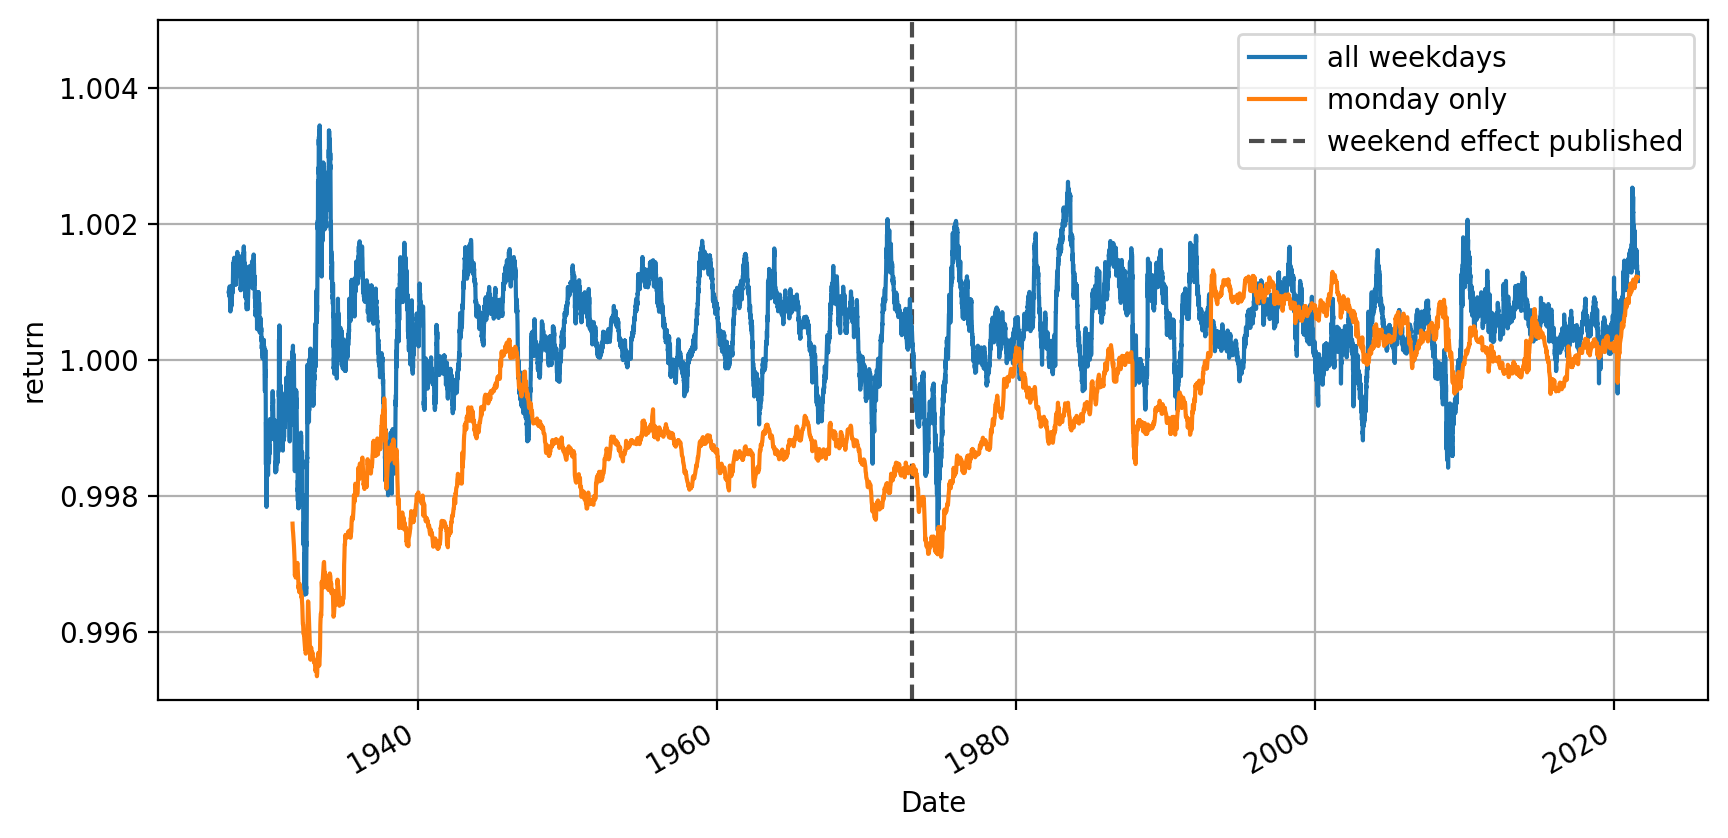

In [ ]:
fig, ax = plt.subplots(dpi=200, figsize=(10,5))

ylim = (0.995, 1.005)
ax.set_ylim(*ylim)
df_industry['Cnsmr'].rolling(window=253 ).mean().plot(ax=ax) # 253 trading days in a year
df_industry[df_industry['is_monday']]['Cnsmr'].rolling(window=253).mean().plot(ax=ax)
ax.vlines(np.datetime64('1973-01-01'), *ylim, linestyles='dashed', alpha=.7)
ax.legend(['all weekdays', 'monday only', 'weekend effect published'])
ax.set_ylabel('return')

# see: https://www.jstor.org/stable/4529641

fig.savefig('weekend_effect.png')

###CAPM tests



In [ ]:
#Get monthly returns on 5 industries, monthly risk free rate, monthly; and 5 factor data monthly; 10 momentum portfolios
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_CSV.zip
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Portfolios_Prior_12_2_CSV.zip

--2021-09-24 09:08:30--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62815 (61K) [application/x-zip-compressed]
Saving to: ‘5_Industry_Portfolios_CSV.zip.2’

5_Industry_Portfoli 100%[===================>]  61.34K   159KB/s    in 0.4s    

2021-09-24 09:08:31 (159 KB/s) - ‘5_Industry_Portfolios_CSV.zip.2’ saved [62815/62815]

--2021-09-24 09:08:32--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10908 (11K) [application/x-zip-compressed]
Savin

In [ ]:
!unzip "5_Industry_Portfolios_CSV.zip" -d ""
!unzip "F-F_Research_Data_5_Factors_2x3_CSV.zip" -d ""
!unzip "10_Portfolios_Prior_12_2_CSV.zip" -d ""

Archive:  5_Industry_Portfolios_CSV.zip
replace 5_Industry_Portfolios.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: 5_Industry_Portfolios.CSV  
Archive:  F-F_Research_Data_5_Factors_2x3_CSV.zip
replace F-F_Research_Data_5_Factors_2x3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: F-F_Research_Data_5_Factors_2x3.csv  
Archive:  10_Portfolios_Prior_12_2_CSV.zip
replace 10_Portfolios_Prior_12_2.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: 10_Portfolios_Prior_12_2.CSV  


In [ ]:
argfooter=4986-1153
df_industry_m = pd.read_csv('5_Industry_Portfolios.CSV',skiprows=11, skipfooter=argfooter,engine='python')
df_industry_m.columns = ['Date', *df_industry_m.columns[1:]]
df_industry_m['Date'] = pd.to_datetime(df_industry_m['Date'], format='%Y%m')
df_industry_m.set_index('Date', inplace=True)


In [ ]:
df_industry_m = df_industry_m/100 

df_industry_m.describe()
df_industry_m.tail()

Cnsmr   Manuf   HiTec   Hlth    Other
Date                                              
2021-03-01  0.0519  0.0720  0.0082  0.0013  0.0563
2021-04-01  0.0583  0.0253  0.0622  0.0289  0.0582
2021-05-01 -0.0170  0.0246 -0.0087  0.0002  0.0294
2021-06-01  0.0238  0.0010  0.0627  0.0428 -0.0246
2021-07-01  0.0011 -0.0010  0.0313  0.0315 -0.0069

In [ ]:
df_ff_m = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, skipfooter=760-700, engine='python')
df_ff_m.columns = ['Date', *df_ff_m.columns[1:]]
df_ff_m['Date'] = pd.to_datetime(df_ff_m['Date'], format='%Y%m')
df_ff_m.set_index('Date', inplace=True)

In [ ]:
# cast to net returns
df_ff_m=df_ff_m/100
df_ff_m.describe()
df_ff_m.tail()

Mkt-RF     SMB     HML     RMW     CMA   RF
Date                                                   
2021-03-01  0.0308 -0.0092  0.0741  0.0635  0.0348  0.0
2021-04-01  0.0493 -0.0310 -0.0093  0.0230 -0.0279  0.0
2021-05-01  0.0029  0.0119  0.0704  0.0234  0.0310  0.0
2021-06-01  0.0279 -0.0025 -0.0776 -0.0214 -0.0099  0.0
2021-07-01  0.0120 -0.0456 -0.0170  0.0536 -0.0053  0.0

In [ ]:
#reading the 10 momentum portfolios, value weighted 
argfooter=4857-1146
df_mom_m = pd.read_csv('10_Portfolios_Prior_12_2.CSV',skiprows=10, skipfooter=argfooter,engine='python')
df_mom_m.columns = ['Date', *df_mom_m.columns[1:]]
df_mom_m['Date'] = pd.to_datetime(df_mom_m['Date'], format='%Y%m')
df_mom_m.set_index('Date', inplace=True)
df_mom_m=df_mom_m/100
df_mom_merged=pd.merge(df_mom_m,df_ff_m, how='inner', left_index=True, right_index=True)
df_mom_merged=df_mom_merged.iloc[:,:10]
df_mom_m.head()
df_mom_merged.head() #momentum portfolio returns for periods for which factor data is available

Lo PRIOR  PRIOR 2  PRIOR 3  ...  PRIOR 8  PRIOR 9  Hi PRIOR
Date                                    ...                            
1963-07-01   -0.0277  -0.0110  -0.0105  ...   0.0051  -0.0055    0.0043
1963-08-01    0.0600   0.0463   0.0577  ...   0.0421   0.0626    0.0923
1963-09-01   -0.0314  -0.0285  -0.0134  ...  -0.0289  -0.0266   -0.0198
1963-10-01    0.0189   0.0167   0.0006  ...   0.0089   0.0825    0.0528
1963-11-01    0.0007  -0.0144  -0.0050  ...  -0.0416  -0.0104   -0.0008

[5 rows x 10 columns]

In [ ]:
df_mom_plus_1 = df_mom_merged + 1
df_mom_plus_1.describe().round(4)

Lo PRIOR   PRIOR 2   PRIOR 3  ...   PRIOR 8   PRIOR 9  Hi PRIOR
count  697.0000  697.0000  697.0000  ...  697.0000  697.0000  697.0000
mean     1.0034    1.0076    1.0090  ...    1.0107    1.0115    1.0152
std      0.0838    0.0640    0.0538  ...    0.0442    0.0475    0.0609
min      0.7182    0.6869    0.7690  ...    0.7950    0.7372    0.7322
25%      0.9604    0.9741    0.9815  ...    0.9851    0.9848    0.9802
50%      1.0018    1.0081    1.0087  ...    1.0128    1.0155    1.0176
75%      1.0412    1.0403    1.0351  ...    1.0374    1.0407    1.0543
max      1.4489    1.3602    1.3314  ...    1.1975    1.2173    1.2179

[8 rows x 10 columns]

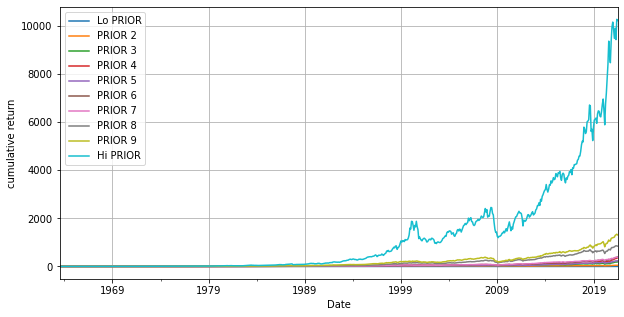

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
df_mom_plus_1.cumprod().plot(ax=ax)
ax.set_ylabel('cumulative return')

fig.savefig('cum_10mom.png', dpi=200)

In [ ]:
#capm tests for industries
X = df_ff_m[['Mkt-RF']].to_numpy().astype('float') # double brackets to return 2d array
X = sm.add_constant(X)
regs=[]
for industry in list(df_industry_m):
  y = df_industry_m[industry].subtract(df_ff_m['RF']).dropna()
  model = sm.OLS(y, X)
  regs.append(model.fit())
  print(industry)
  print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary())


Cnsmr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     1495.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          2.07e-175
Time:                        09:09:02   Log-Likelihood:                 1777.6
No. Observations:                 697   AIC:                            -3551.
Df Residuals:                     695   BIC:                            -3542.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.595   

In [ ]:
stargazer = Stargazer(regs[:3])
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n const & 0.001$^{*}$ & 0.000$^{}$ & 0.000$^{}$ \\\\\n  & (0.001) & (0.001) & (0.001) \\\\\n x1 & 0.928$^{***}$ & 0.891$^{***}$ & 1.090$^{***}$ \\\\\n  & (0.016) & (0.016) & (0.020) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 697 & 697 & 697 \\\\\n $R^2$ & 0.827 & 0.826 & 0.805 \\\\\n Adjusted $R^2$ & 0.827 & 0.825 & 0.805 \\\\\n Residual Std. Error & 0.019(df = 695) & 0.018(df = 695) & 0.024(df = 695)  \\\\\n F Statistic & 3319.204$^{***}$ (df = 1.0; 695.0) & 3293.485$^{***}$ (df = 1.0; 695.0) & 2870.448$^{***}$ (df = 1.0; 695.0) \\\\\n\\hline\n\\hline \\\\[-1.8ex]\n\\textit{Note:} & \\multicolumn{3}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\\\\n\\end{tabular}\n\\end{table}'

### Capm & Momentum


In [ ]:
#we use a high momentum portfolio, and conduct the same regression as above; high alpha suggests capm does not capture momentum
X = df_ff_m[['Mkt-RF']].to_numpy().astype('float') 
X = sm.add_constant(X)
regs=[]

y = df_mom_m['Hi PRIOR'].subtract(df_ff_m['RF']).dropna()
model = sm.OLS(y, X)
print('Hi PRIOR')
print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary())
regs.append(model.fit())

#statistically significant positive alpha; capm does not seem to capture momentum

Hi PRIOR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     959.8
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          4.70e-133
Time:                        09:09:04   Log-Likelihood:                 1402.4
No. Observations:                 697   AIC:                            -2801.
Df Residuals:                     695   BIC:                            -2792.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      3.747

In [ ]:
stargazer = Stargazer(regs)
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{1-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n const & 0.005$^{***}$ \\\\\n  & (0.001) \\\\\n x1 & 1.161$^{***}$ \\\\\n  & (0.028) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 697 \\\\\n $R^2$ & 0.718 \\\\\n Adjusted $R^2$ & 0.718 \\\\\n Residual Std. Error & 0.032(df = 695)  \\\\\n F Statistic & 1770.818$^{***}$ (df = 1.0; 695.0) \\\\\n\\hline\n\\hline \\\\[-1.8ex]\n\\textit{Note:} & \\multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\\\\n\\end{tabular}\n\\end{table}'

###5 Factors

In [ ]:
#test 5 factors model for industry portfolios
X = df_ff_m.iloc[:, :5].to_numpy().astype('float') #  don't select RF
names_ff=list(df_ff_m.iloc[:,:5]) #names of the 5 factors for reporting
X = sm.add_constant(X)
regs=[]
for industry in list(df_industry_m):
  y = df_industry_m[industry].subtract(df_ff_m['RF']).dropna()
  model = sm.OLS(y, X)
  print(industry)
  print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary(xname=list(['constant', *names_ff ])))
  regs.append(model.fit())


Cnsmr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     481.3
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          2.58e-222
Time:                        09:09:06   Log-Likelihood:                 1882.4
No. Observations:                 697   AIC:                            -3753.
Df Residuals:                     691   BIC:                            -3725.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.0011      0.001     -1.681   

In [ ]:
stargazer = Stargazer(regs)
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{5}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{5-6}\n\\\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\\\\n\\hline \\\\[-1.8ex]\n const & -0.001$^{*}$ & -0.002$^{**}$ & 0.003$^{***}$ & 0.002$^{*}$ & -0.002$^{***}$ \\\\\n  & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) \\\\\n x1 & 0.985$^{***}$ & 0.970$^{***}$ & 0.979$^{***}$ & 0.878$^{***}$ & 1.130$^{***}$ \\\\\n  & (0.016) & (0.016) & (0.019) & (0.028) & (0.015) \\\\\n x2 & 0.124$^{***}$ & -0.003$^{}$ & -0.058$^{**}$ & -0.119$^{***}$ & 0.091$^{***}$ \\\\\n  & (0.022) & (0.022) & (0.027) & (0.039) & (0.022) \\\\\n x3 & -0.030$^{}$ & 0.136$^{***}$ & -0.209$^{***}$ & -0.416$^{***}$ & 0.461$^{***}$ \\\\\n  & (0.029) & (0.029) & (0.035) & (0.051) & (0.029) \\\\\n x4 & 0.458$^{***}$ & 0.254$^{***}$ & -0.425$^{***}$ & 0.317$^{***}$ & 0.128$^{***}$ \\\\\n  & (0.031) & (0.031) & (0.037) & (0.054) & 

In [ ]:
#again estimate ff model; now for high momentum portfolio; high alpha suggests momentum not captured by ff
X = df_ff_m.iloc[:, :5].to_numpy().astype('float') #  don't select RF
X = sm.add_constant(X)
regs=[]

y = df_mom_m['Hi PRIOR'].subtract(df_ff_m['RF']).dropna()
model = sm.OLS(y, X)
regs.append(model.fit())
print('Hi PRIOR')
print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary(xname=list(['constant', *names_ff ])))
#Positive and statistically significant alpha

Hi PRIOR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     251.3
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          8.31e-153
Time:                        09:09:08   Log-Likelihood:                 1485.2
No. Observations:                 697   AIC:                            -2958.
Df Residuals:                     691   BIC:                            -2931.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0058      0.001      4.559

In [ ]:
stargazer = Stargazer(regs)
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{1-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n const & 0.006$^{***}$ \\\\\n  & (0.001) \\\\\n x1 & 1.032$^{***}$ \\\\\n  & (0.028) \\\\\n x2 & 0.363$^{***}$ \\\\\n  & (0.040) \\\\\n x3 & -0.361$^{***}$ \\\\\n  & (0.052) \\\\\n x4 & -0.034$^{}$ \\\\\n  & (0.055) \\\\\n x5 & -0.032$^{}$ \\\\\n  & (0.081) \\\\\n\\hline \\\\[-1.8ex]\n Observations & 697 \\\\\n $R^2$ & 0.778 \\\\\n Adjusted $R^2$ & 0.776 \\\\\n Residual Std. Error & 0.029(df = 691)  \\\\\n F Statistic & 483.530$^{***}$ (df = 5.0; 691.0) \\\\\n\\hline\n\\hline \\\\[-1.8ex]\n\\textit{Note:} & \\multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\\\\n\\end{tabular}\n\\end{table}'

FF & Momentum


### Replicating figure 6 in Cochrane (2011) with momentum

In [ ]:
#run 5 factor regression for each of the mom portfolios separately; collect coefficients for the plot, also estimate capm beta for each portf.
df_ff_m.head()
list(df_ff_m.iloc[:,:5])


['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

In [ ]:
X = df_ff_m.iloc[:, :5].to_numpy().astype('float') # double brackets to return 2d array
X_1=df_ff_m[['Mkt-RF']].to_numpy().astype('float')
X = sm.add_constant(X)
X_1=sm.add_constant(X_1)
coeffs=pd.DataFrame(columns=['Constant', *names_ff], index=list(df_mom_m) )
betas=pd.DataFrame(columns=[r'$\beta$'], index=list(df_mom_m) )
regs=[]
for portf in list(df_mom_m):
  l=[]
  b=[]
  y = df_mom_m[portf].subtract(df_ff_m['RF']).dropna() #get excess return of portf
  model = sm.OLS(y, X)
  model1=sm.OLS(y, X_1) #for beta estimation
  #l.append(portf)
  l.extend(model.fit().params)
  b.extend(model1.fit().params)
  #coeffs.append(l)
  coeffs.loc[portf] = l
  betas.loc[portf]=b[1]
  regs.append(model)
  print(portf)
  print(model.fit().get_robustcov_results(cov_type='HAC', maxlags=1).summary(xname=list(['constant', *names_ff ])))
  

Lo PRIOR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     104.0
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           9.35e-82
Time:                        09:09:13   Log-Likelihood:                 1134.4
No. Observations:                 697   AIC:                            -2257.
Df Residuals:                     691   BIC:                            -2230.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.0079      0.002     -3.874

In [ ]:
regs
stargazer = Stargazer([x.fit() for x in regs])
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcccccccccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{10}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{10-11}\n\\\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) & (10) \\\\\n\\hline \\\\[-1.8ex]\n const & -0.008$^{***}$ & -0.004$^{***}$ & -0.002$^{**}$ & -0.001$^{}$ & -0.001$^{**}$ & -0.001$^{}$ & -0.001$^{*}$ & 0.000$^{}$ & 0.001$^{}$ & 0.006$^{***}$ \\\\\n  & (0.002) & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) & (0.001) \\\\\n x1 & 1.358$^{***}$ & 1.204$^{***}$ & 1.071$^{***}$ & 1.040$^{***}$ & 0.970$^{***}$ & 1.000$^{***}$ & 0.973$^{***}$ & 0.964$^{***}$ & 0.996$^{***}$ & 1.032$^{***}$ \\\\\n  & (0.046) & (0.031) & (0.025) & (0.019) & (0.016) & (0.015) & (0.015) & (0.016) & (0.019) & (0.028) \\\\\n x2 & 0.379$^{***}$ & 0.144$^{***}$ & 0.056$^{}$ & 0.002$^{}$ & -0.007$^{}$ & -0.010$^{}$ & -0.042$^{**}$ & 0.019$^{}$ & 0.068$^{**}$ & 0.

In [ ]:
coeffs
betas

$\beta$
Lo PRIOR   1.49481
PRIOR 2    1.22393
PRIOR 3    1.03793
PRIOR 4   0.985844
PRIOR 5   0.926596
PRIOR 6   0.947801
PRIOR 7   0.900846
PRIOR 8   0.917832
PRIOR 9   0.969099
Hi PRIOR   1.16103

In [ ]:
#compute average value for each of the 5 factors. Compute average return for each of the 10 portfolios. (over same time period?)
#factors
average_ff=pd.DataFrame()
coefs=['a','b','c','d', '\delta', '']
for factor in names_ff:
  average_ff[factor+'x coef']=df_ff_m[factor].mean()*coeffs[factor]
avg_r=list(df_mom_merged.mean())      #only take average over same horizon as we have for portfolios
average_ff['avg_r']=avg_r
average_ff[r'$\beta E(mkt-rf)$']=betas*df_ff_m['Mkt-RF'].mean()


In [ ]:
coeffs

Constant    Mkt-RF         SMB        HML        RMW        CMA
Lo PRIOR  -0.00791666   1.35761    0.378979   0.511347  -0.435746  -0.543682
PRIOR 2   -0.00371094   1.20425     0.14386   0.435896 -0.0583975  -0.272532
PRIOR 3   -0.00208587   1.07134    0.056432   0.369718   0.108388  -0.099712
PRIOR 4     -0.001261   1.03999  0.00171087    0.22571   0.175341  0.0392978
PRIOR 5   -0.00144012  0.969722 -0.00747328   0.230588   0.183133 -0.0458826
PRIOR 6  -0.000983747   1.00025 -0.00979411   0.142159   0.223569   0.055952
PRIOR 7   -0.00109429  0.973381  -0.0418535   0.029454   0.275648    0.20063
PRIOR 8   0.000277029  0.963957   0.0191438 -0.0239098    0.26551   0.163163
PRIOR 9    0.00088892   0.99616   0.0676004 -0.0398512   0.307355  0.0941408
Hi PRIOR   0.00575766   1.03249    0.362697  -0.361437 -0.0335533 -0.0316422

In [ ]:
average_ff=average_ff*100 #(in acccordance with cochrane)
average_ff #these are (coefficient of portfolio i wrt factor k)*(avg value of factor k)

Mkt-RFx coef    SMBx coef  ...     avg_r $\beta E(mkt-rf)$
Lo PRIOR     0.792535    0.0895249  ...  0.337819          0.872629
PRIOR 2       0.70301    0.0339835  ...  0.763128          0.714499
PRIOR 3      0.625421    0.0133307  ...  0.898852          0.605914
PRIOR 4      0.607116  0.000404153  ...  0.966026          0.575509
PRIOR 5      0.566098  -0.00176539  ...  0.885839          0.540922
PRIOR 6      0.583919  -0.00231363  ...  0.962683          0.553301
PRIOR 7      0.568234  -0.00988691  ...  0.950187           0.52589
PRIOR 8      0.562733   0.00452228  ...  1.069598          0.535806
PRIOR 9      0.581532     0.015969  ...  1.149570          0.565734
Hi PRIOR     0.602742    0.0856786  ...  1.520215          0.677777

[10 rows x 7 columns]

In [ ]:
average_ff = average_ff.rename(columns={'SMBx coef': '$aE[SMB]$',
                                        'HMLx coef':'$cE[HML]$', 'RMWx coef': '$\delta E[RMW] $', 
                                        'CMAx coef': '$h E[CMA]$'})

In [ ]:
#plot analogous to fig6 Cochrane (add capm line?)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 10), sharey='col', dpi=1200)
#plt.figure(dpi=1200)

colors = ['red', 'black', 'magenta', 'purple']
markers=['o', 's', 'p', '*']
#plt.suptitle('Five factor contributions to momentum portfolio returns', fontsize=20)


for i in  range(4):
    average_ff.iloc[:,i+1].plot(ax=ax[i], marker='p', color=colors[i])
    average_ff['Mkt-RFx coef'].plot(ax=ax[i], marker='*', label='$bE[mkt-rf]$')
    average_ff[r'$\beta E(mkt-rf)$'].plot(ax=ax[i], marker='o', linestyle='--')
    average_ff['avg_r'].plot(ax=ax[i], marker='s', label='E[r]')
    ax[i].legend()
    ax[i].set_xticks([0,9])
    ax[i].set_xticklabels(['Low Momentum','High Momentum'])
    ax[i].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6 ])
    ax[i].grid(False)
   # if i>1:
   #   ax[i].set_yticks(locs)
   #   ax[i].set_yticklabels(labels)
   # locs, labels = plt.yticks()
    
#fig.align_ylabels(ax[:])

#fig.savefig("Cochrane Graph") 
plt.show()



#plt.show()
#high momentum firms outperform their capm prediction
#do numbers make sense?
#higher average return than Cochrane (2011)

### GMM Part

In [ ]:
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_CSV.zip
!wget https://scholar.harvard.edu/files/barro/files/barro_ursua_macrodataset_1110.xls
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip
!wget https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip

--2021-09-24 07:52:23--  https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/5_Industry_Portfolios_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62815 (61K) [application/x-zip-compressed]
Saving to: ‘5_Industry_Portfolios_CSV.zip.1’

5_Industry_Portfoli 100%[===================>]  61.34K  --.-KB/s    in 0.04s   

2021-09-24 07:52:23 (1.49 MB/s) - ‘5_Industry_Portfolios_CSV.zip.1’ saved [62815/62815]

--2021-09-24 07:52:23--  https://scholar.harvard.edu/files/barro/files/barro_ursua_macrodataset_1110.xls
Resolving scholar.harvard.edu (scholar.harvard.edu)... 18.208.82.203, 18.232.209.104
Connecting to scholar.harvard.edu (scholar.harvard.edu)|18.208.82.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7516672 (7.2M) [application/vnd.ms-excel]
Saving to: ‘barro_urs

In [ ]:
!unzip "5_Industry_Portfolios_CSV.zip" -d ""
!unzip "F-F_Research_Data_5_Factors_2x3_CSV.zip" -d ""
!unzip "F-F_Momentum_Factor_CSV.zip" -d ""

Archive:  5_Industry_Portfolios_CSV.zip
replace 5_Industry_Portfolios.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  F-F_Research_Data_5_Factors_2x3_CSV.zip
replace F-F_Research_Data_5_Factors_2x3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: m
error:  invalid response [m]
replace F-F_Research_Data_5_Factors_2x3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  F-F_Momentum_Factor_CSV.zip
replace F-F_Momentum_Factor.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# skip first rows (explanation of data), and last rows (average weighted returns (we weigh by value for now!))
df_industry = pd.read_csv('5_Industry_Portfolios.CSV', skiprows=11, skipfooter=3831, engine='python')



df_industry.columns = ['Date', *df_industry.columns[1:]]
df_industry['Date'] = pd.to_datetime(df_industry['Date'], format='%Y%m')
df_industry.set_index('Date', inplace=True)

#cast to returns
df_industry = df_industry/100 + 1

In [ ]:
df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=2, skipfooter= 59, engine='python')
df_ff.columns = ['Date', *df_ff.columns[1:]]
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format='%Y%m')
df_ff.set_index('Date', inplace=True)

# cast to returns
df_ff = df_ff/100 + 1

In [ ]:
df_mom = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=12, skipfooter= 99, engine='python')

df_mom.columns = ['Date', *df_mom.columns[1:]]
df_mom['Date'] = pd.to_datetime(df_mom['Date'], format='%Y%m')
df_mom.set_index('Date', inplace=True)

#cast to returns
df_mom = df_mom/100 + 1

In [ ]:
df_monthly = df_ff.merge(df_mom, left_index=True, right_index=True).merge(df_industry, left_index=True, right_index=True)

In [ ]:
df_macro = pd.read_excel('barro_ursua_macrodataset_1110.xls', sheet_name='C', usecols=[0, 41], skiprows=45, names=['Date', 'C'])
df_macro['Date'] = pd.to_datetime(df_macro['Date'], format='%Y')
df_macro.set_index('Date', inplace=True)

In [ ]:
# r = industry portfolios + momentum
r = df_monthly.iloc[:, -6:].to_numpy()

T = r.shape[0]
J = r.shape[1]

# Vector of ones
iotaT = np.ones(T)
iotaJ = np.ones(J)

# r = Mkt-Rf and constant
f = np.stack([iotaT, df_monthly.iloc[:, 0].to_numpy()]).T

# a and B
a = -iotaJ
B = -(1/T)*(r.T @ f)

# first round W identity matrix
W = np.eye(J)
# first round estimates
first_round = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ a)
SDF = f @ first_round
moment = np.tile(iotaJ, (T, 1)) - np.tile(SDF, (J, 1)).T * r
S = (1/T) * moment.T @ moment
Vfirst = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ S @ W @ B) @ np.linalg.inv(B.T @ W @ B)
stde_first = np.sqrt(np.diag(Vfirst/T))

pd.DataFrame(np.stack([first_round, stde_first]).T, index=['alpha', 'Mkt-RF'], columns=['estimate', 'std. err.']).round(3)

estimate  std. err.
alpha      2.583      1.114
Mkt-RF    -1.581      1.104

In [ ]:
# second round
# new W = S^-1
W = np.linalg.inv(S)

second_round = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ a)
SDF = f @ second_round
moment = np.tile(iotaJ, (T, 1)) - np.tile(SDF, (J, 1)).T * r
S = (1/T) * moment.T @ moment
Vsnd = np.linalg.inv(B.T @ W @ B)
stde_snd = np.sqrt(np.diag(Vsnd/T))

pd.DataFrame(np.stack([second_round, stde_snd]).T, index=['alpha', 'Mkt-RF'], columns=['estimate', 'std. err.']).round(3)

estimate  std. err.
alpha      2.508      1.106
Mkt-RF    -1.506      1.097

In [ ]:
mu_moment = np.mean(moment, axis=0)
HansenJ = T*mu_moment.T @ np.linalg.inv(S) @ mu_moment

#chi2 and p value (cannot reject validity)
HansenJ, 1 - chi2.cdf(HansenJ, J - f.shape[1])

(3.404712132842597, 0.4925141653128916)

In [ ]:
# r = industry and momentum
r = df_monthly.iloc[:, 6:].to_numpy()

T = r.shape[0]
J = r.shape[1]

# Vector of ones
iotaT = np.ones(T)
iotaJ = np.ones(J)

# f = fama french
f = np.hstack([iotaT.reshape(-1, 1), df_monthly.iloc[:, :5].to_numpy()])

# a and B
a = -iotaJ
B = -(1/T)*(r.T @ f)

# first round W identity matrix
W = np.eye(J)
# first round estimates
first_round = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ a)
SDF = f @ first_round
moment = np.tile(iotaJ, (T, 1)) - np.tile(SDF, (J, 1)).T * r
S = (1/T) * moment.T @ moment
Vfirst = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ S @ W @ B) @ np.linalg.inv(B.T @ W @ B)
stde_first = np.sqrt(np.diag(Vfirst/T))

pd.DataFrame(np.stack([first_round, stde_first]).T, index=['constant', *df_monthly.columns[:5]], columns=['estimate', 'std. err.'])

estimate  std. err.
constant  2.134994  22.531267
Mkt-RF   -1.954328   2.965151
SMB       1.105241   9.136938
HML       1.629097  11.590821
RMW      -7.603472   8.535356
CMA       5.692361  30.208023

In [ ]:
# second round
# new W = S^-1
W = np.linalg.inv(S)

second_round = np.linalg.inv(B.T @ W @ B) @ (B.T @ W @ a)
SDF = f @ second_round
moment = np.tile(iotaJ, (T, 1)) - np.tile(SDF, (J, 1)).T * r
S = (1/T) * moment.T @ moment
Vsnd = np.linalg.inv(B.T @ W @ B)
stde_snd = np.sqrt(np.diag(Vsnd/T))

pd.DataFrame(np.stack([second_round, stde_snd]).T, index=['constant', *df_monthly.columns[:5]], columns=['estimate', 'std. err.']).round(3)

estimate  std. err.
constant     2.135     22.524
Mkt-RF      -1.954      2.966
SMB          1.105      9.139
HML          1.629     11.600
RMW         -7.603      8.535
CMA          5.692     30.230

In [ ]:
# Convert data to stata format for question 6c)
df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=703, skipfooter=0, engine='python')
df_ff.columns = ['Date', *df_ff.columns[1:]]
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format='%Y')
df_ff.set_index('Date', inplace=True)

# cast to returns
df_ff = df_ff/100 + 1

df_industry = pd.read_csv('5_Industry_Portfolios.CSV', skiprows=2301, skipfooter=4984-2396, engine='python')
df_industry.columns = ['Date', *df_industry.columns[1:]]
df_industry['Date'] = pd.to_datetime(df_industry['Date'], format='%Y')
df_industry.set_index('Date', inplace=True)

#cast to returns
df_industry = df_industry/100 + 1

df_stata = df_macro.merge(df_ff, left_index=True, right_index=True).merge(df_industry, left_index=True, right_index=True)

df_stata['c_ret'] = df_stata['C']/df_stata['C'].shift(1)
df_stata = df_stata.iloc[1:]
df_stata['Mkt'] = df_stata['Mkt-RF'] + df_stata['RF'] - 1

df_stata.to_stata('ef_assignment_annual.dta')

/usr/local/lib/python3.7/dist-packages/pandas/io/stata.py:2400: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Mkt-RF   ->   Mkt_RF
    Hlth    ->   Hlth_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)
